### Idea

Create a Markov Chain to analyze how different types of students are led to the different paths. The feature space will be a reduced space clustered with spectral clustering

#### Import libraries

In [65]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster

# Helpers
import numpy as np
import pickle

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD

# Distance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, pairwise_kernels

# Learning
from clustering import Clustering
from questions.sampling import get_next_sample

# Visualization
from plot2d import Plot2D
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport


%matplotlib inline

In [2]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=132)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print(problems.count())
problems = Problem.objects.filter(id__lte=132)
problems.count()

591


132

In [3]:
solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')

In [4]:
solutions_obj.count()

54

In [106]:
vocabulary = []
for sol in solutions_obj:
    file = io.StringIO(sol.content)
    print(sol.content)
    for item in tokenize.generate_tokens(file.readline):
#     print(list(tokenize.generate_tokens(file.readline)))
        print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
        vocabulary.append(item[1])

def list_ends(a_list):
    return [a_list[0], a_list[len(a_list)-1]]
NAME def
NAME list_ends
OP (
NAME a_list
OP )
OP :
NEWLINE 

INDENT     
NAME return
OP [
NAME a_list
OP [
NUMBER 0
OP ]
OP ,
NAME a_list
OP [
NAME len
OP (
NAME a_list
OP )
OP -
NUMBER 1
OP ]
OP ]
DEDENT 
ENDMARKER 
def reverseWord(w):
  return ' '.join(w.split()[::-1])
NAME def
NAME reverseWord
OP (
NAME w
OP )
OP :
NEWLINE 

INDENT   
NAME return
STRING ' '
OP .
NAME join
OP (
NAME w
OP .
NAME split
OP (
OP )
OP [
OP :
OP :
OP -
NUMBER 1
OP ]
OP )
DEDENT 
ENDMARKER 
def max_of_three(a,b,c):
     max_3=0
     if a>b:
         #max_3=a
         if a>c:
             max_3=a
         else:
             max_3=c
     else:
          if b>c:
             max_3=b
          else:
             max_3=c
     return max_3
NAME def
NAME max_of_three
OP (
NAME a
OP ,
NAME b
OP ,
NAME c
OP )
OP :
NEWLINE 

INDENT      
NAME max_3
OP =
NUMBER 0
NEWLINE 

NAME if
NAME a
OP >
NAME b
OP :
NEWLINE 

COMMENT #max_3=a
NL 

INDENT        

NAME shopping_list
OP [
NAME element
OP ]
NEWLINE 

NAME shopping_list
OP [
NAME element
OP ]
OP =
NAME shopping_list
OP [
NAME element
OP +
NUMBER 1
OP ]
NEWLINE 

NAME shopping_list
OP [
NAME element
OP +
NUMBER 1
OP ]
OP =
NAME temp
NEWLINE 

DEDENT 
DEDENT 
DEDENT 
NAME return
NAME shopping_list
DEDENT 
ENDMARKER 
def divisible():
    l=[]
    for i in range(2000, 3201):
        if (i%7==0) and (i%5!=0):
            l.append(i)
    return l


NAME def
NAME divisible
OP (
OP )
OP :
NEWLINE 

INDENT     
NAME l
OP =
OP [
OP ]
NEWLINE 

NAME for
NAME i
NAME in
NAME range
OP (
NUMBER 2000
OP ,
NUMBER 3201
OP )
OP :
NEWLINE 

INDENT         
NAME if
OP (
NAME i
OP %
NUMBER 7
OP ==
NUMBER 0
OP )
NAME and
OP (
NAME i
OP %
NUMBER 5
OP !=
NUMBER 0
OP )
OP :
NEWLINE 

INDENT             
NAME l
OP .
NAME append
OP (
NAME i
OP )
NEWLINE 

DEDENT 
DEDENT 
NAME return
NAME l
NEWLINE 

NL 

DEDENT 
ENDMARKER 
def fatorial(number):
    total = 1

    for i in range(number, 1, -1):
        total =

In [109]:
set(vocabulary)

{'',
 '\t',
 '\n',
 '\r\n',
 '  ',
 '    ',
 '     ',
 '      ',
 '        ',
 '         ',
 '          ',
 '            ',
 '             ',
 '                ',
 '!=',
 '" "',
 '" You can retire in {0} years."',
 '""',
 '"%s"',
 '", "',
 '","',
 '"0"',
 '"00000000"',
 '"1"',
 '"Both Team One and Team Two score 1 point."',
 '"Character not found."',
 '"D"',
 '"DOWN"',
 '"LEFT"',
 '"RIGHT"',
 '"Team One scores 3 points and Team Two scores 0 points."',
 '"Team Two scores 3 points and Team One scores 0 points."',
 '"UP"',
 '"W"',
 '"You are old enough to vote."',
 '"You can vote in {0} years."',
 '"[$#@]"',
 '"[0-9]"',
 '"[A-Z]"',
 '"[a-z]"',
 '"\\s"',
 '"autumn"',
 '"digits"',
 '"letters"',
 '"lowercase"',
 '"spring"',
 '"summer"',
 '"uppercase"',
 '"winter"',
 '"{0}"',
 '"{0}{1}"',
 '"{0}{1}{2}"',
 '"{0}{1}{2}{3}"',
 '#',
 '# Complete your function using this header',
 '# So it works using eval',
 "# don't forget to initialise the running total before you start",
 '# frequency of words

In [111]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP', 'INDENT', 'DEDENT']
# cursor = db.conn.cursor()
docs = []
docs_id = []
# doc_category = []
errors = []
questions = []
solutions = []

# lendo os dados
# cursor.execute("""
# SELECT solution.id, solution.content, problem.content, problem.category FROM solution, problem where solution.problem_id = problem.id;
# """)

for sol in solutions_obj:
    file = io.StringIO(sol.content)
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (sol.id))
    
    if doc == []:
        continue
    docs.append(' '.join(doc))
    docs_id.append(sol.id)
#     doc_category.append(row[-1])
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 54 documents
Success in parsing all documents! You may go on!


***Limitação do parser: variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

### Preprocessing solutions into bag of words ###

In [112]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
#                              stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(54, 17)

In [113]:
feature_names = vectorizer.get_feature_names()
feature_names

['append',
 'def',
 'elif',
 'else',
 'false',
 'for',
 'if',
 'in',
 'int',
 'join',
 'len',
 'not',
 'number',
 'range',
 'return',
 'split',
 'true']

In [52]:
# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]
docs_id = np.asarray(docs_id)[~(train_data_features==0).all(1)]
# doc_category = np.asarray(doc_category)[~(train_data_features==0).all(1)]
questions = np.asarray(questions)[~(train_data_features==0).all(1)]
solution_sample.shape

(54, 17)

### Reducing dimensionality

[ 22.8  39.8  56.2  71.7  80.   86.5  90.5  93.4  95.6  97.   98.2  99.
  99.4  99.8 100.  100.1 100.1]


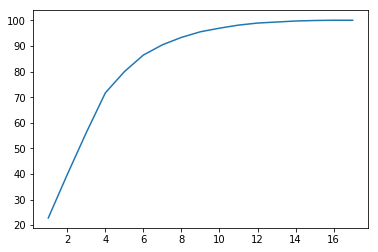

In [53]:
solution_reduced = PCA(n_components=solution_sample.shape[1])
solution_reduced.fit(solution_sample)

# Calculate cumulative sum of explained variance percentage
var=np.cumsum(np.round(solution_reduced.explained_variance_ratio_, decimals=3)*100)
plt.plot(list(range(1,len(var)+1)), var)

print(var)

### Cluster solutions

In [55]:
def _generate_random_state():
    seed = np.random.randint(2**32 - 1)
    return seed
seed = _generate_random_state()
solution_reduced = PCA(n_components=0.85, random_state=seed).fit(solution_sample)
# solution_reduced = PCA(n_components=3, random_state=seed).fit(solution_sample)
solution_sample_reduced = solution_reduced.transform(solution_sample)
seed = _generate_random_state()
# document_topic = cluster.SpectralClustering(n_clusters=3, 
#                                         assign_labels="discretize").fit_predict(X)

In [56]:
solution_sample.shape

(54, 17)

3953377391


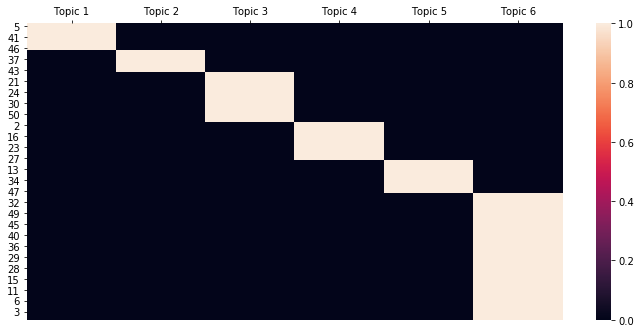

Count per class:
Topic 1: 5
Topic 2: 4
Topic 3: 9
Topic 4: 7
Topic 5: 6
Topic 6: 23


In [78]:
# clustering = Clustering(handler.X, )
clustering = Clustering(solution_sample_reduced, 6)
# clustering.seed = 2209808447
#2124056991
#232156180
#2539469571
# clustering.seed = 0
# clustering._generate_random_state()
model, document_topic, word_topic = clustering.spectral_clustering()
# model, document_topic, word_topic = clustering.gaussian_mixture()
# model, document_topic, word_topic = clustering.lda()
print(clustering.seed)
clustering.plot_topic_distribution()

print("Count per class:")
clusters = clustering.document_topic.argmax(axis=1)
counts = np.unique(clusters, return_counts=True)
for i in range(clustering.k):
    print("Topic %d: %d" % ((i+1), counts[1][i]))

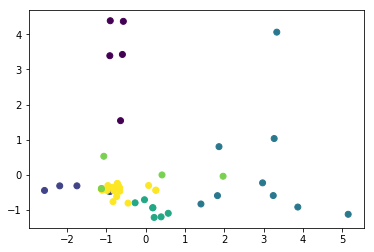

In [79]:
plt.scatter(solution_sample_reduced[:,0], solution_sample_reduced[:,1], c=clusters)

In [80]:
def print_top_words(topic_word, feature_names, n_top_words):
    for topic_idx, topic in enumerate(topic_word):
        message = "Topic #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [81]:
print("\nWords per topic:")
feature_names = vectorizer.get_feature_names()
print_top_words(word_topic, feature_names, 10)


Words per topic:


TypeError: 'NoneType' object is not iterable

### Get next sample

Set initial matrices

In [82]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = np.zeros(clustering.document_topic.shape) # nS x nC
print(X.shape)

# Create Y as a document_topic matrix. For the first version, each document belongs to one topic
Y_col = clustering.document_topic.argmax(axis=1) # nS x nC
Y = np.zeros(clustering.document_topic.shape)
for idx in range(Y.shape[0]):
    Y[idx, Y_col[idx]] = 1

# Create W as a similarity matrix
W = cosine_similarity(clustering.X) # nS x nS
print(W.shape)

with open('similarity.pkl', 'wb') as picklefile:
    pickle.dump(W, picklefile)

# Set L as an unlabelled set
L = []

(54, 6)
(54, 54)


#### Visualization
Reduce to 2 dimensions using TSNE

1737028437


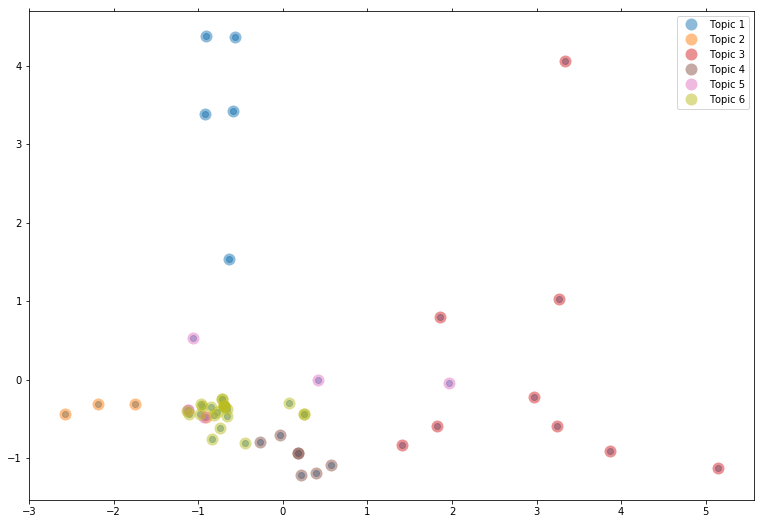

In [83]:
# %%time
# cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
cluster_names = ["Topic %d" % (i+1) for i in range(clustering.k)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
handler._generate_random_state()
# handler.seed = 14875623
handler.reduce(solution_sample_reduced)
print(handler.seed)
handler.plot(show_clusters=True)

sample = handler.X
y = clustering.document_topic.argmax(axis=1)

# fig = plt.figure(figsize=(10,5))
# plt.scatter(x=sample[:,0], y=sample[:,1], c=y, s=100)

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


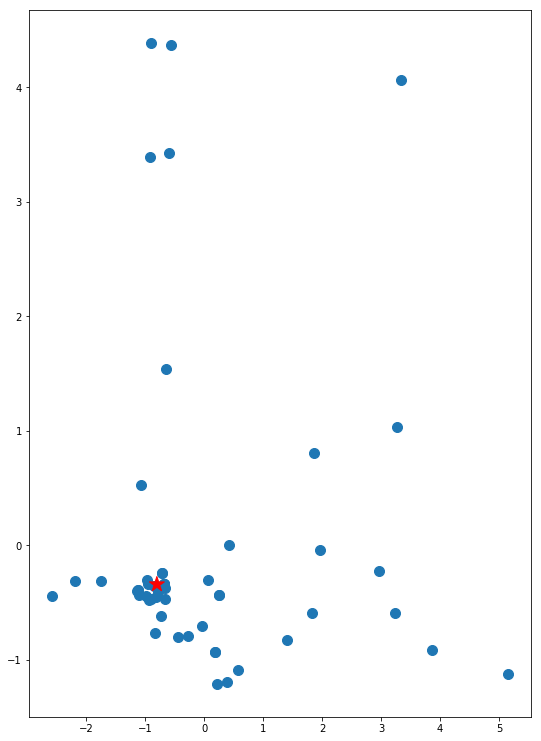

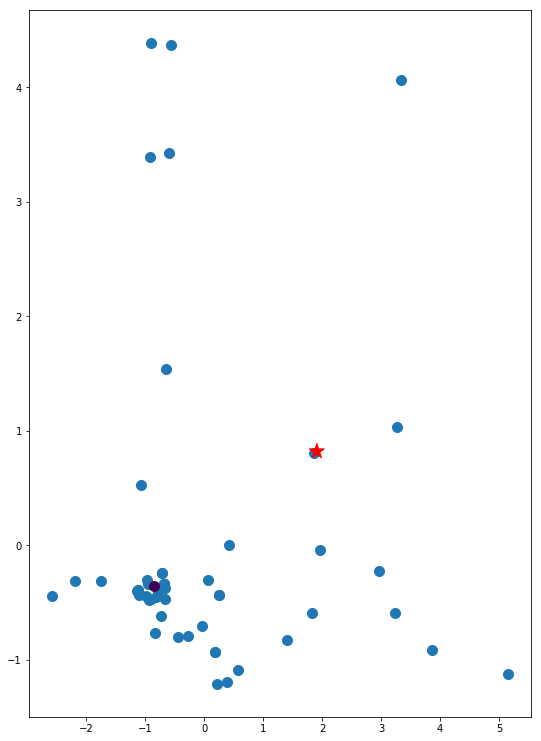

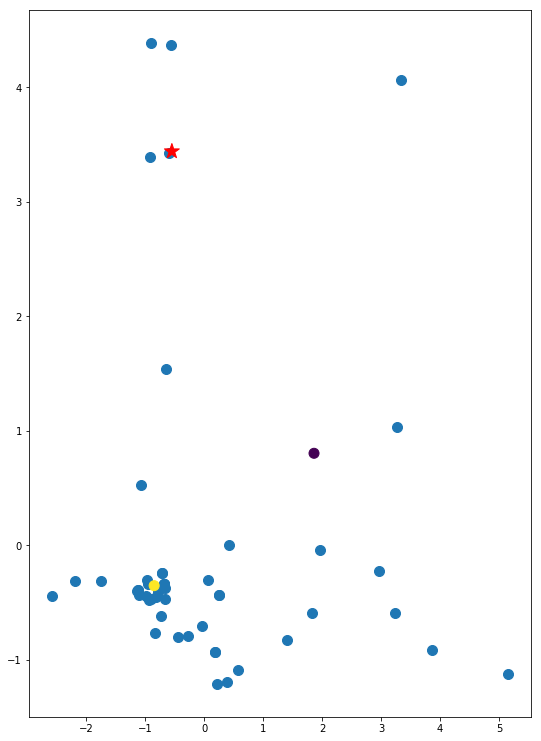

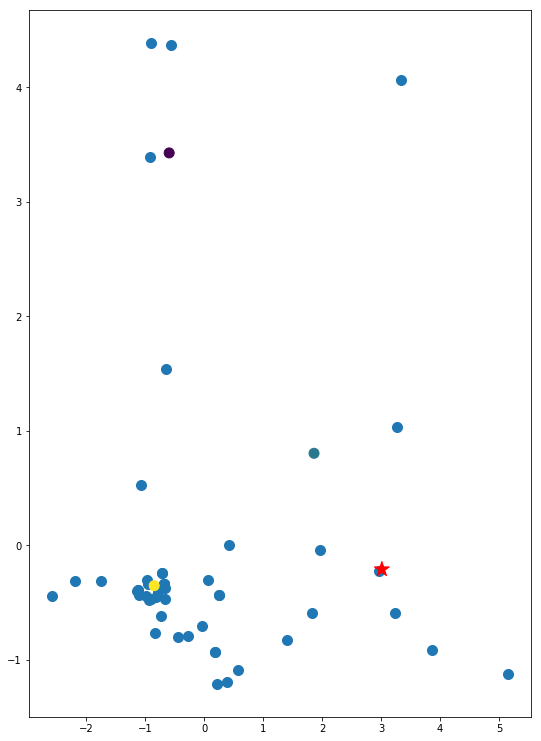

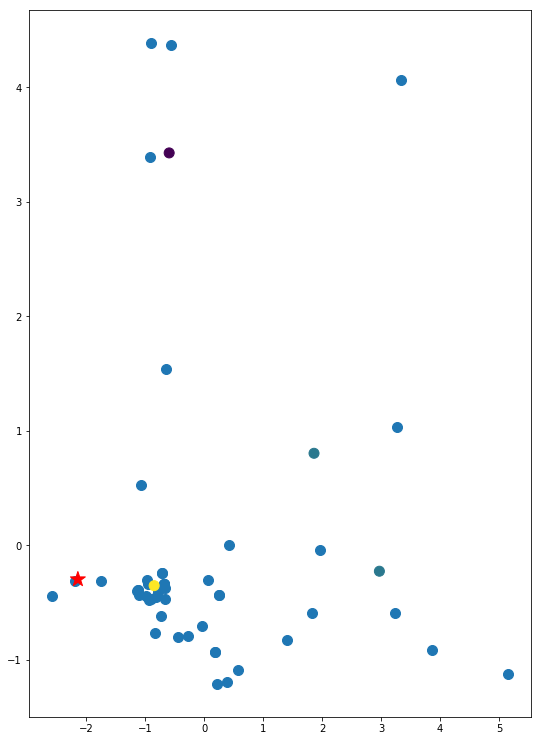

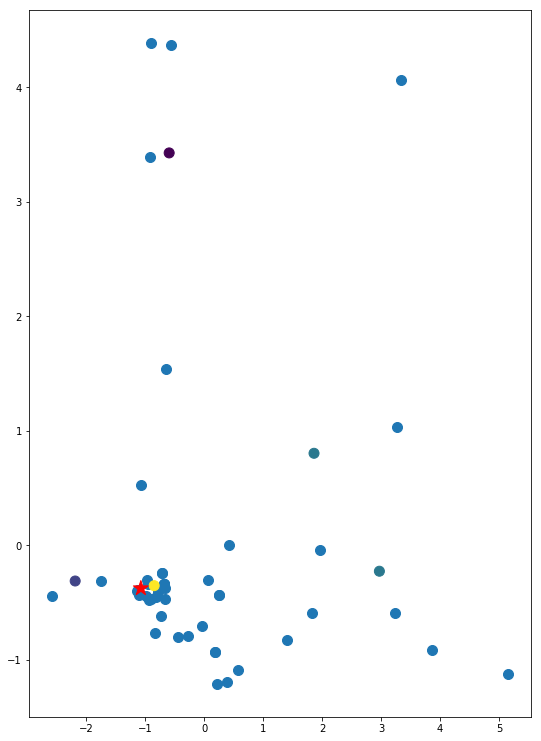

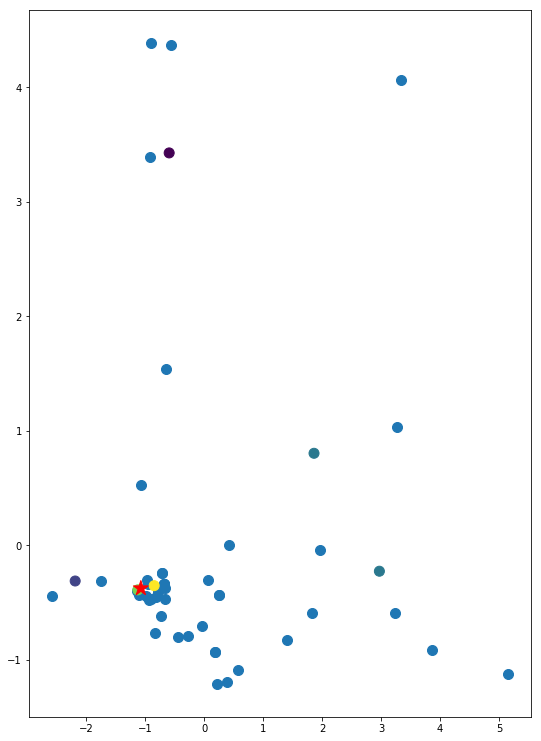

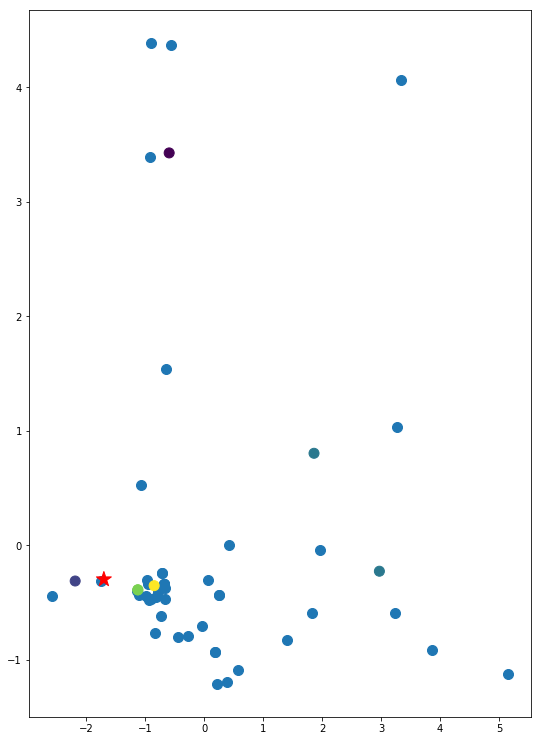

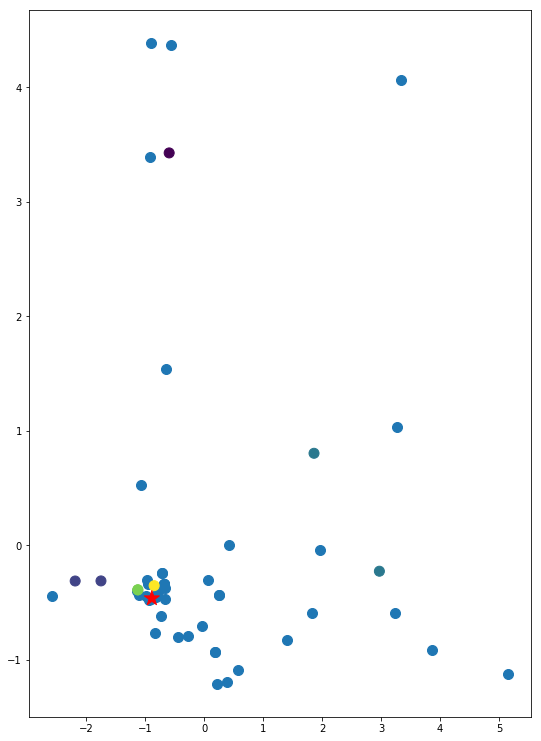

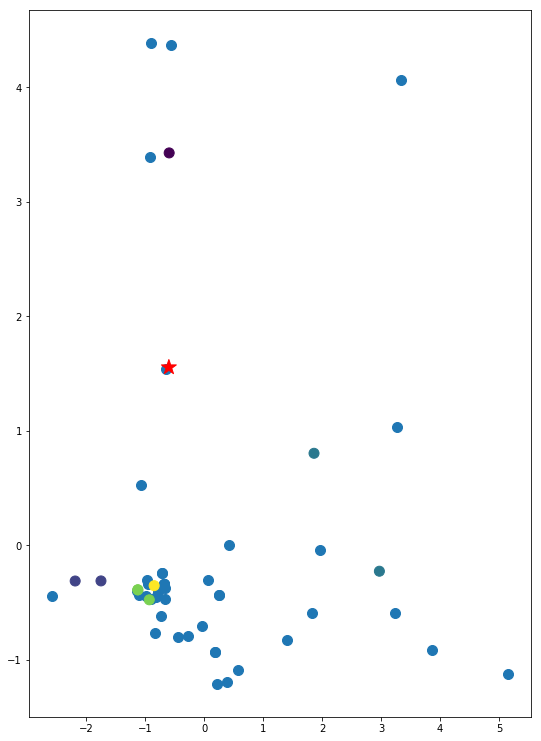

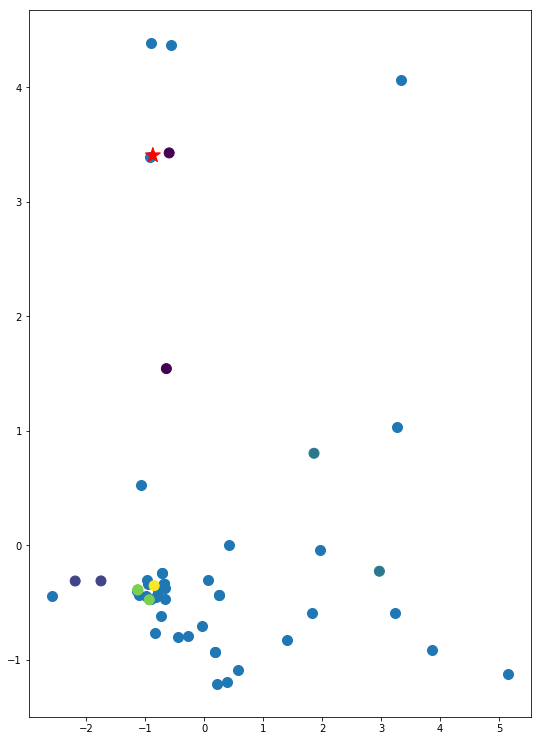

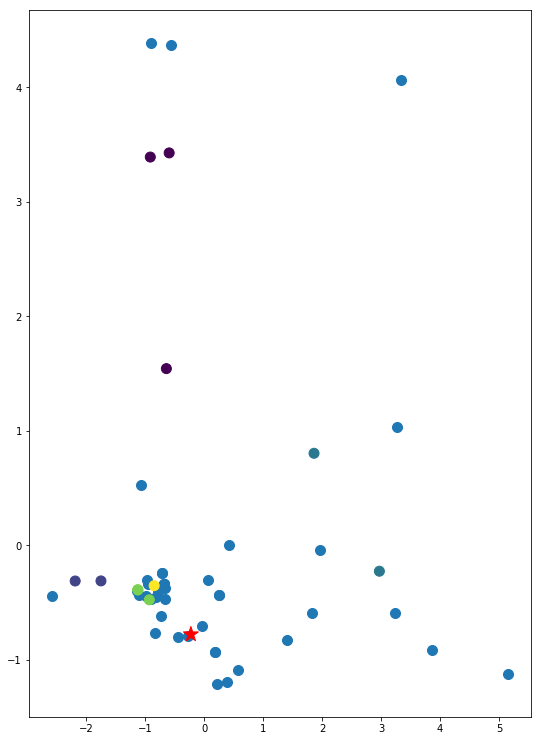

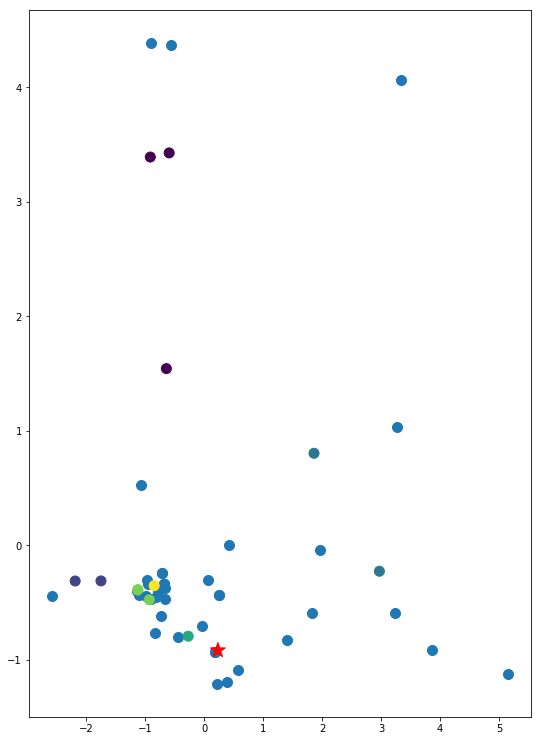

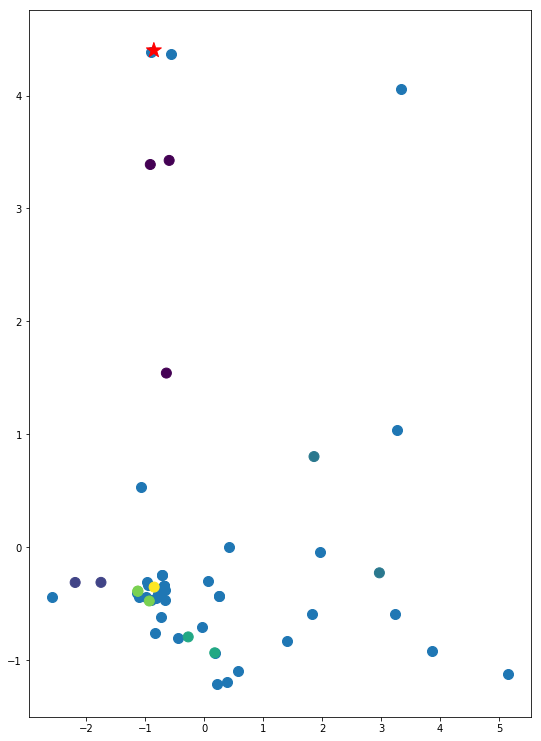

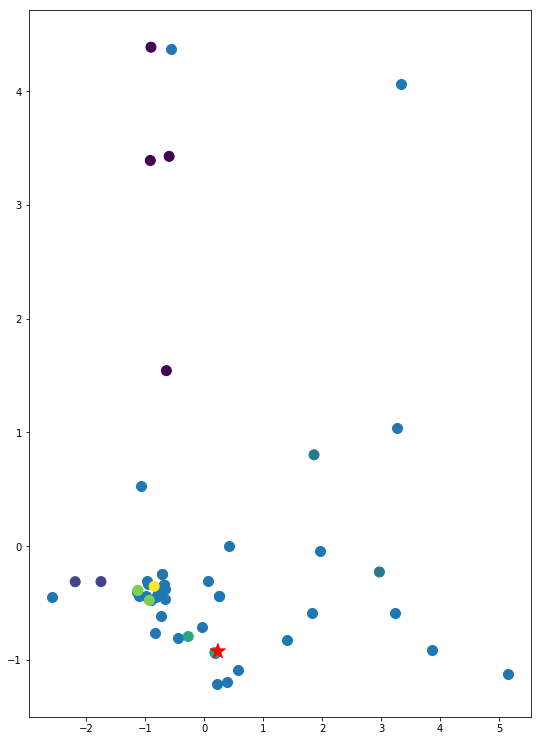

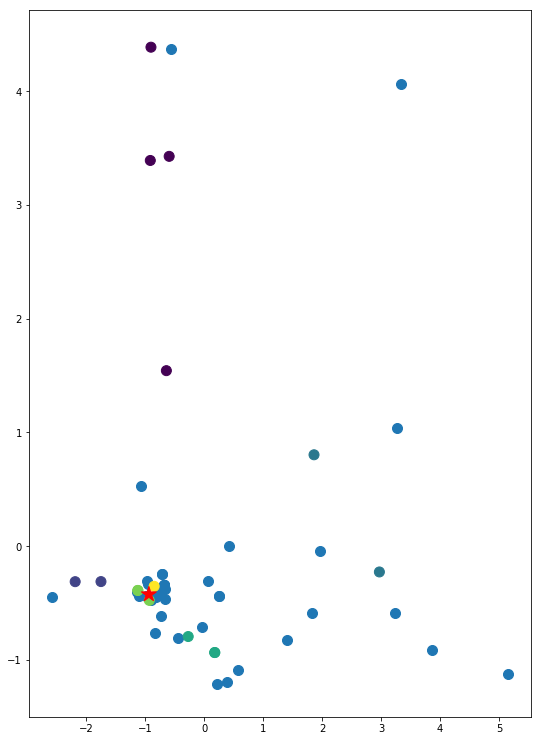

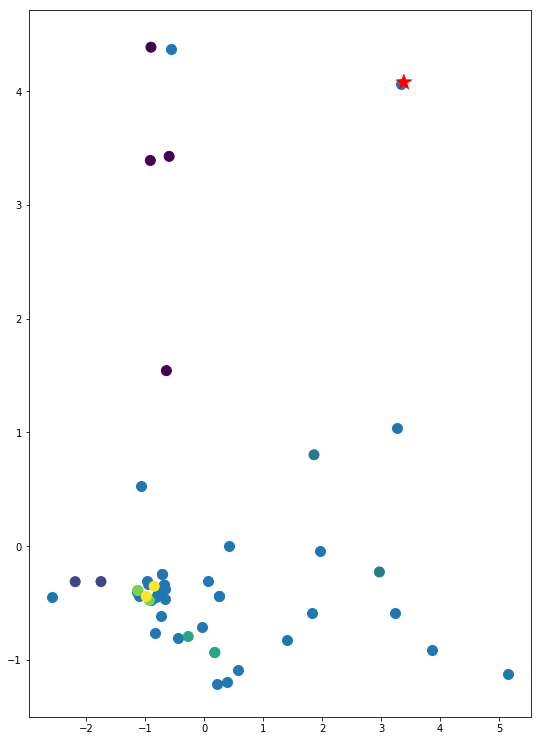

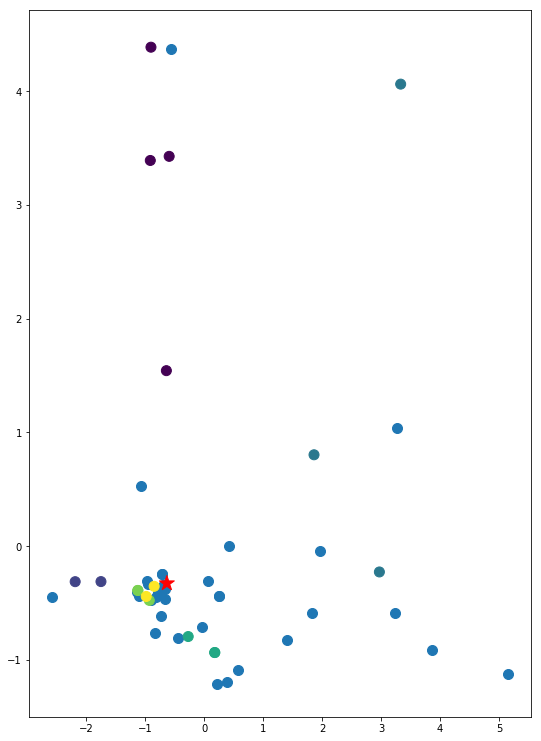

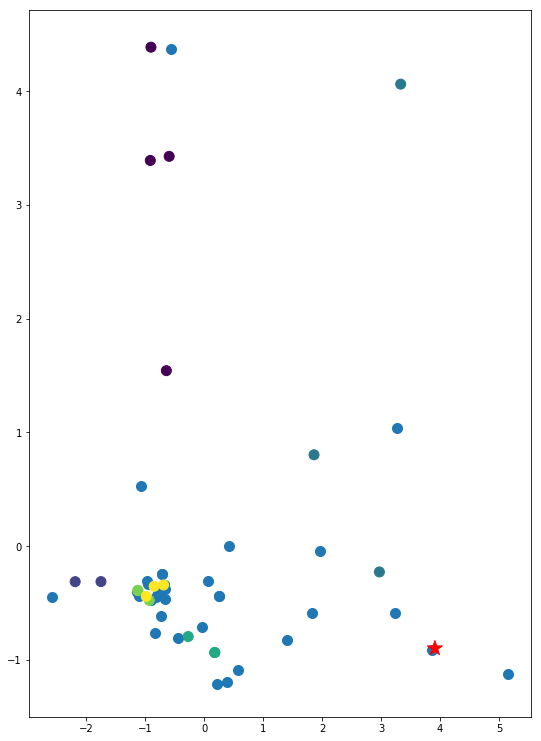

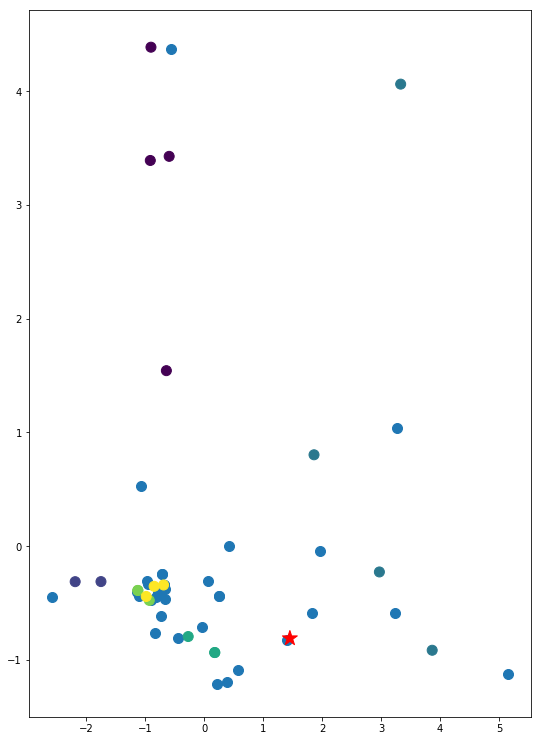

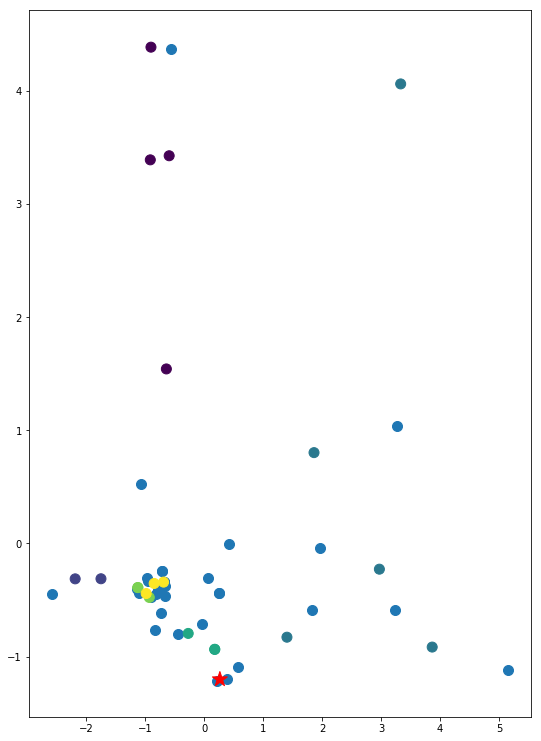

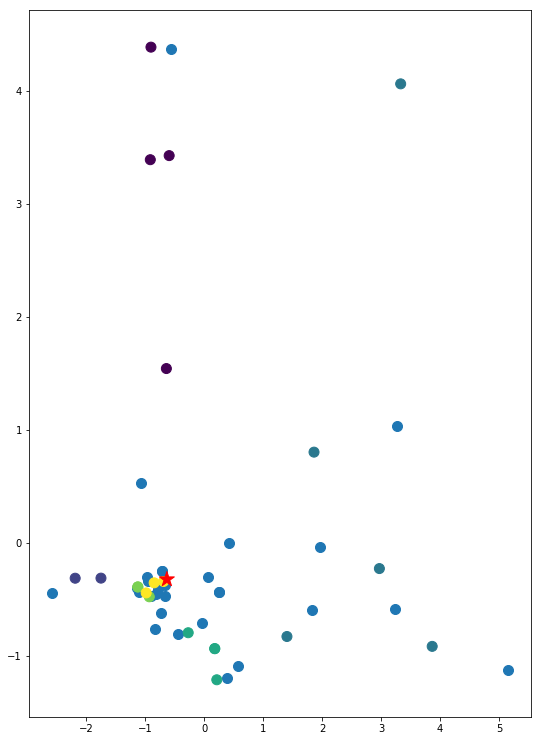

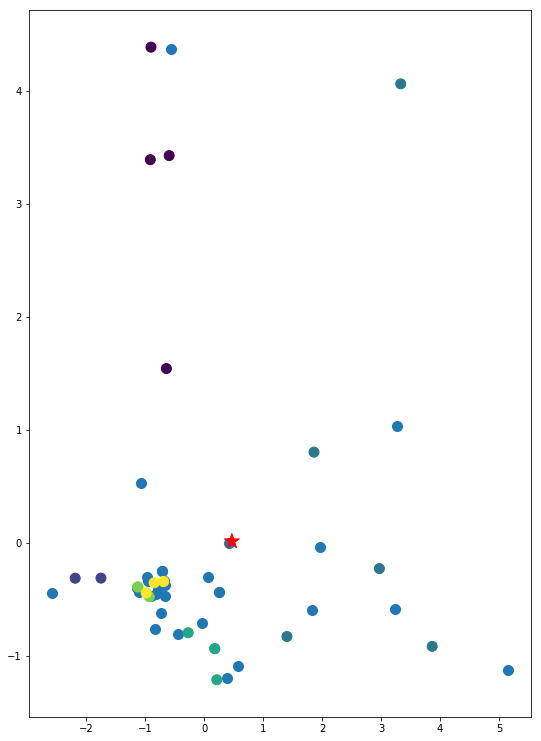

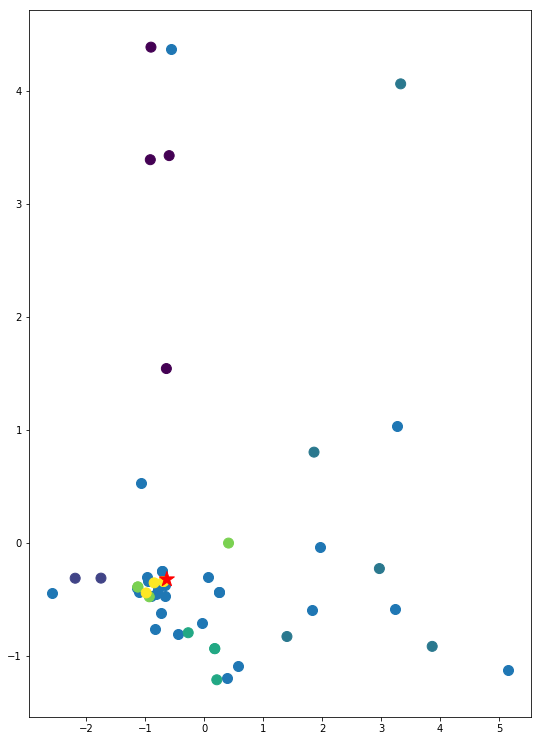

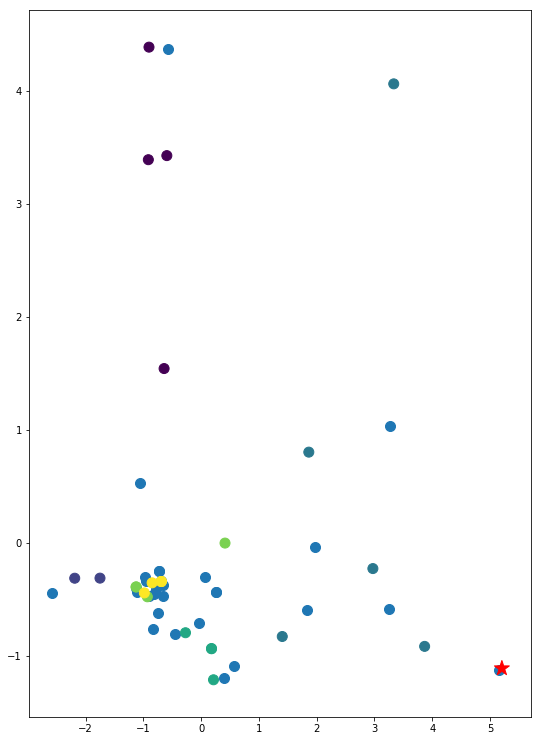

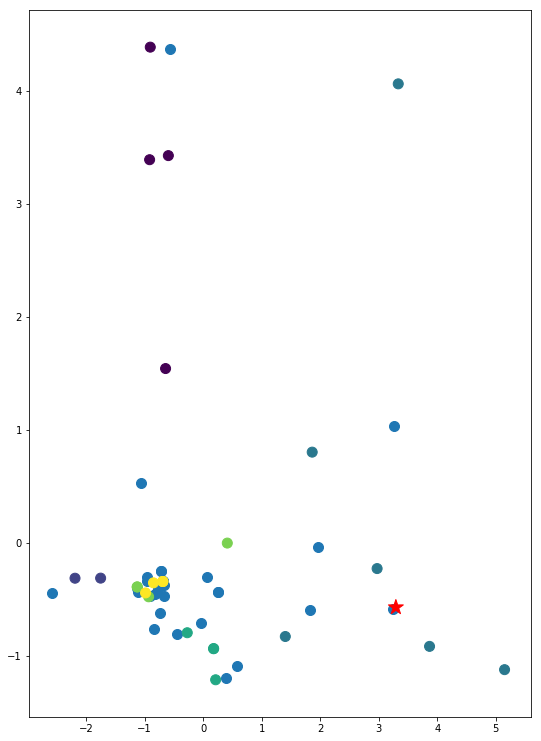

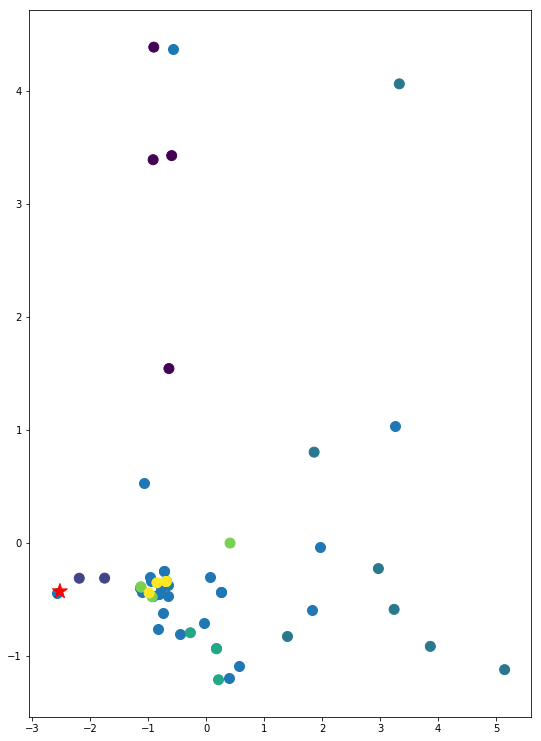

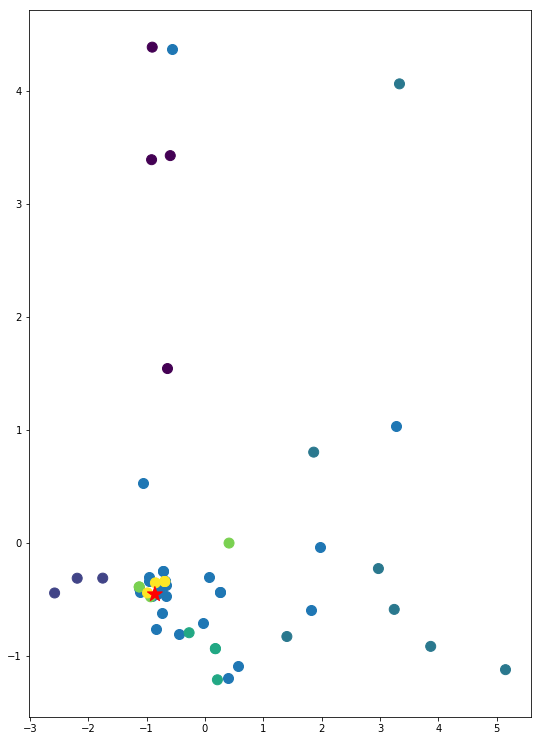

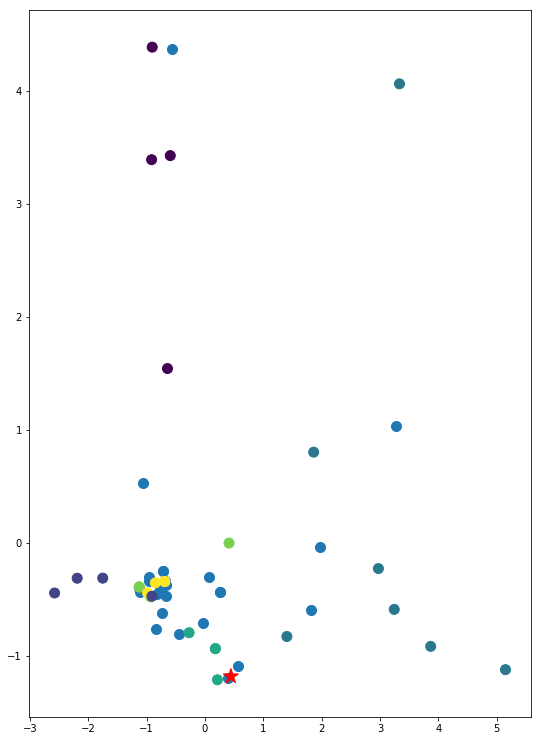

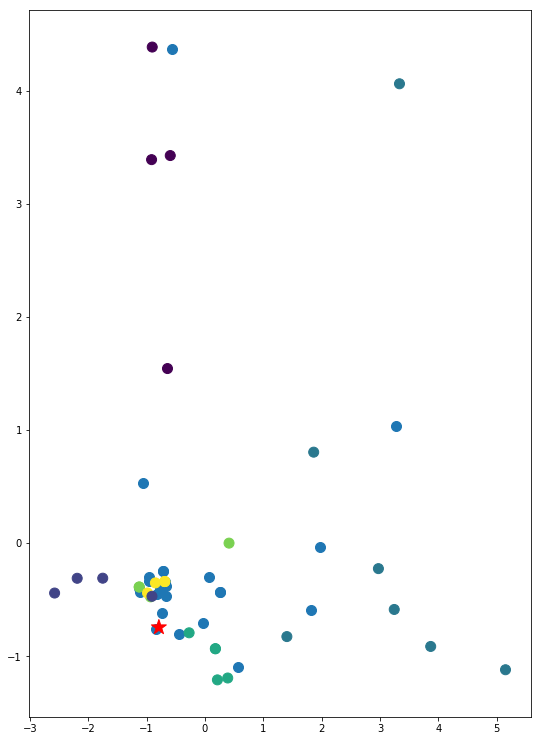

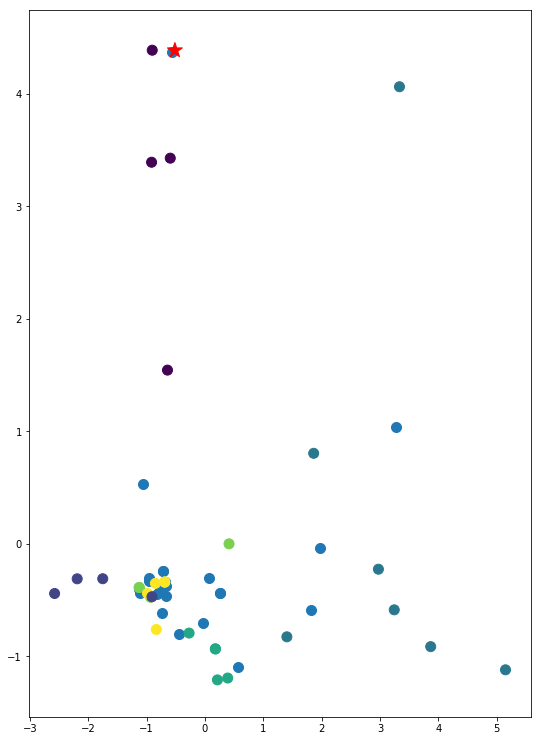

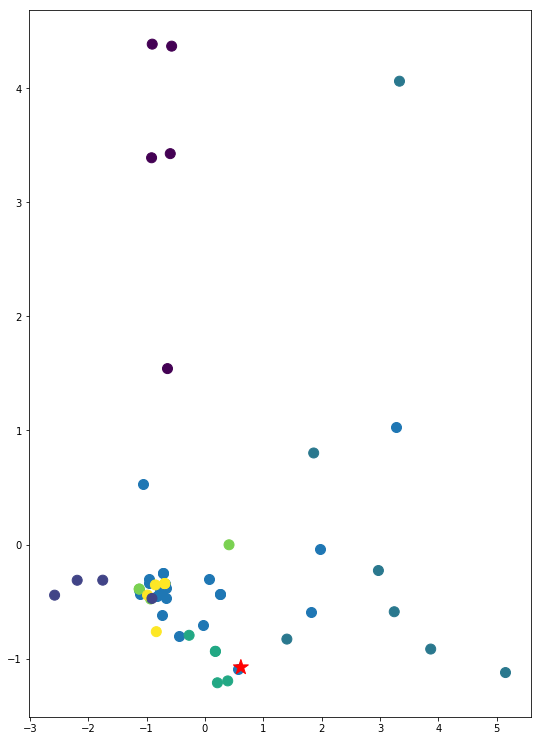

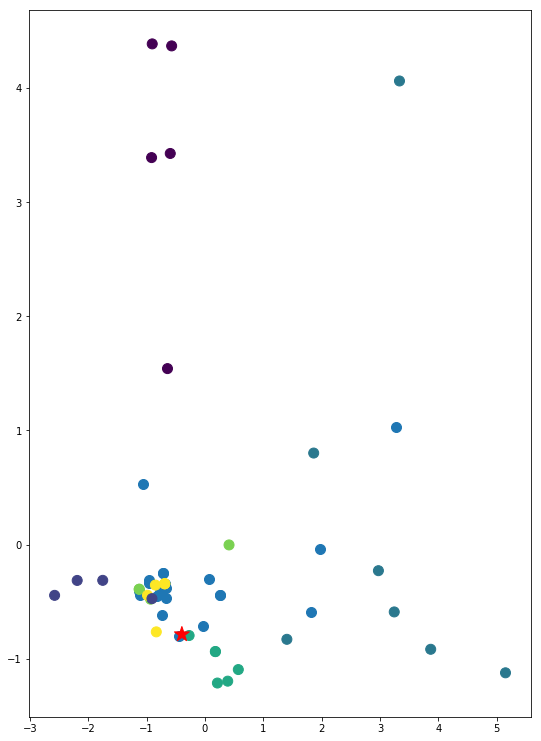

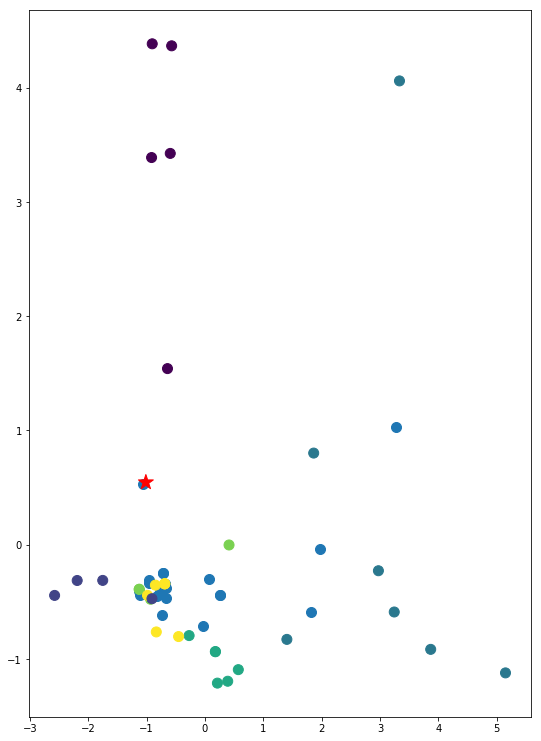

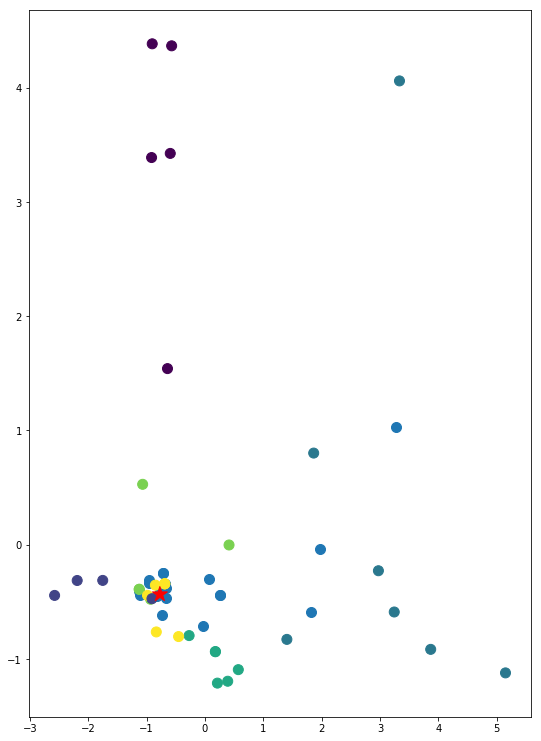

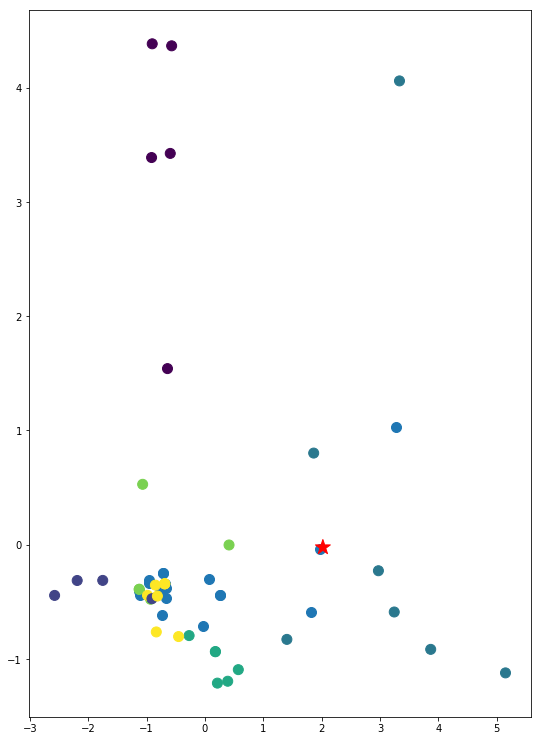

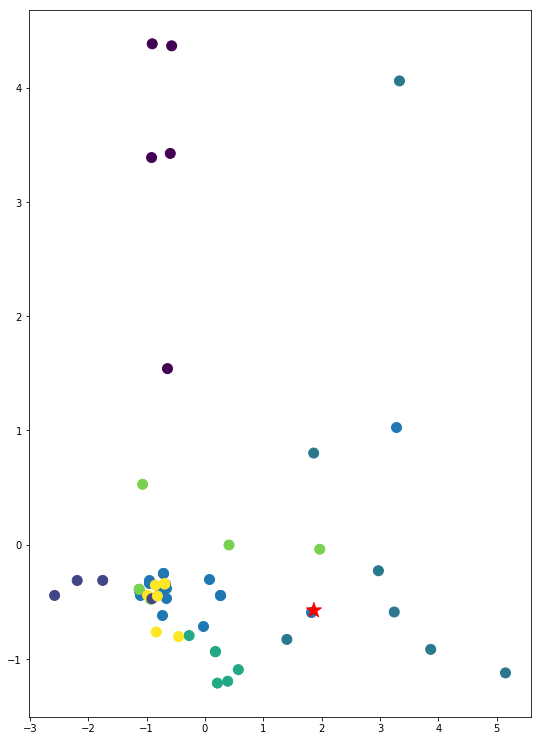

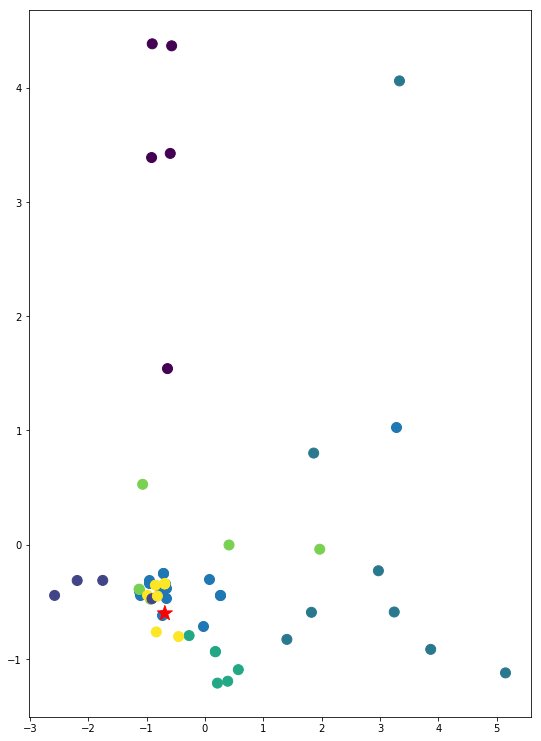

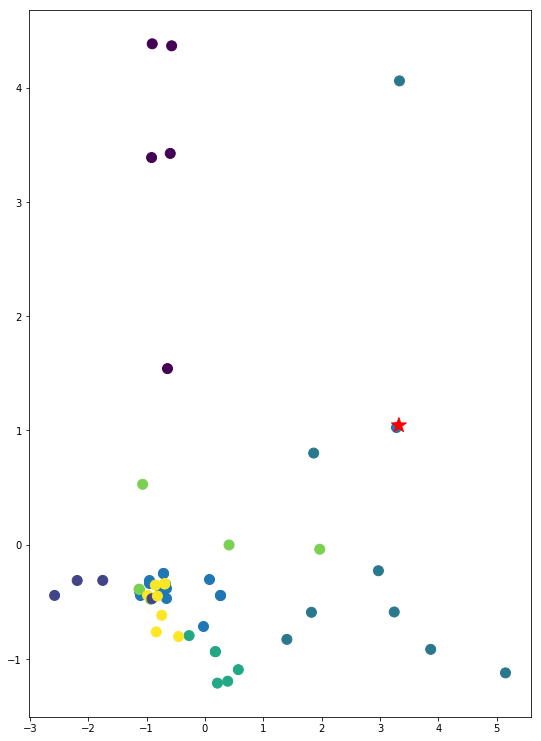

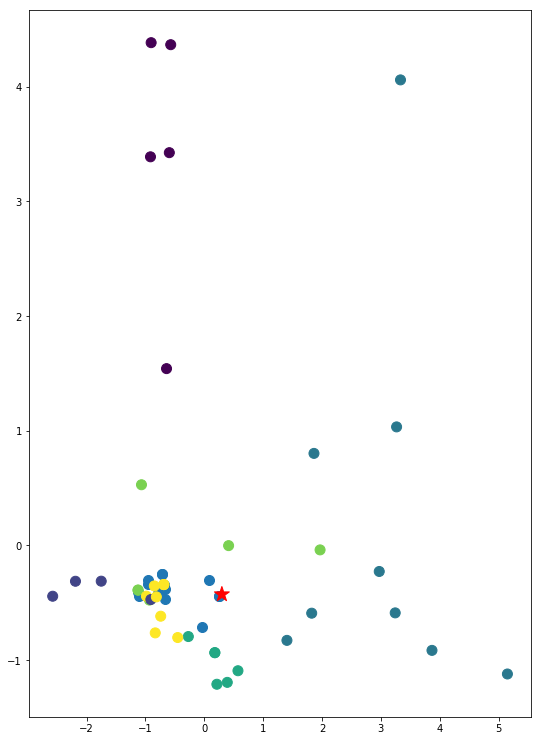

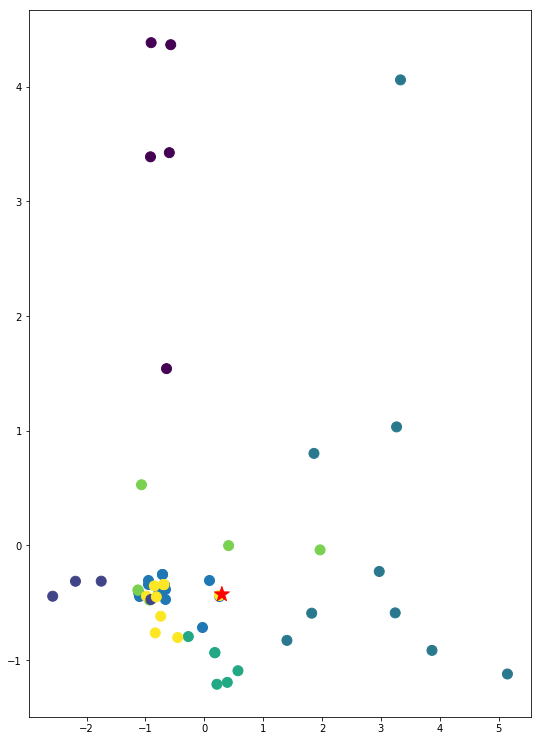

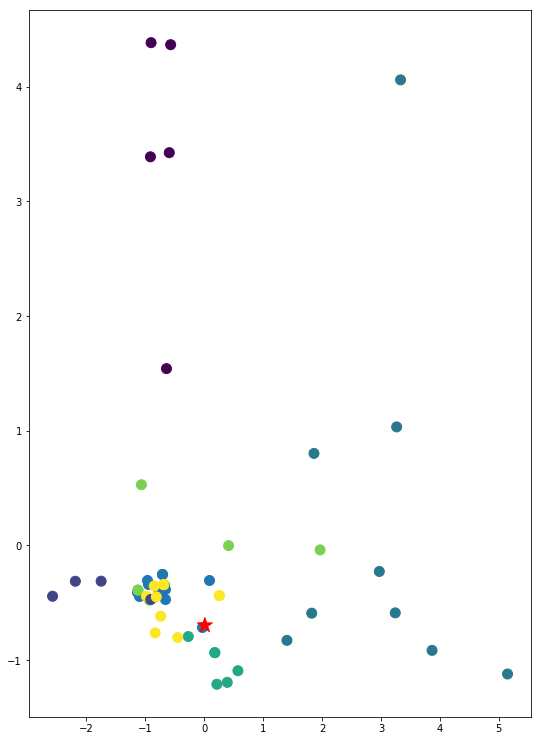

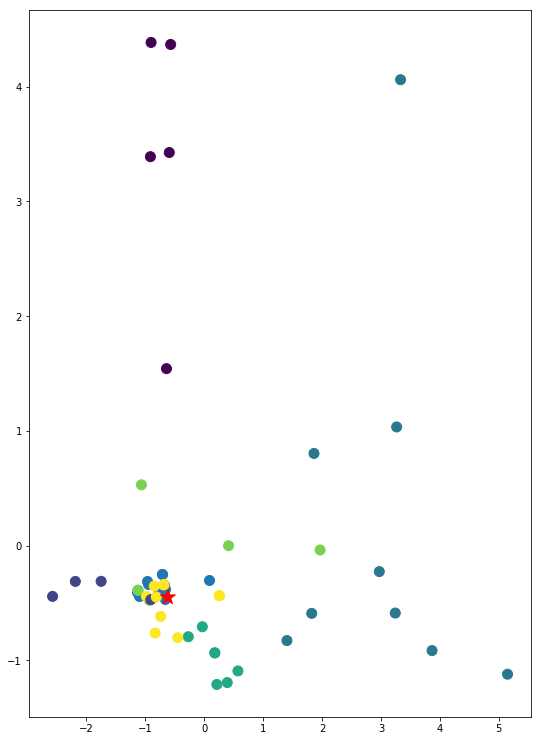

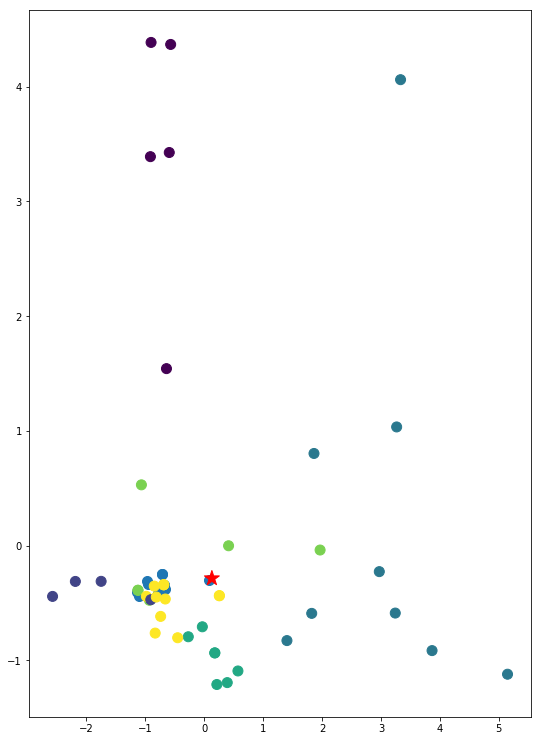

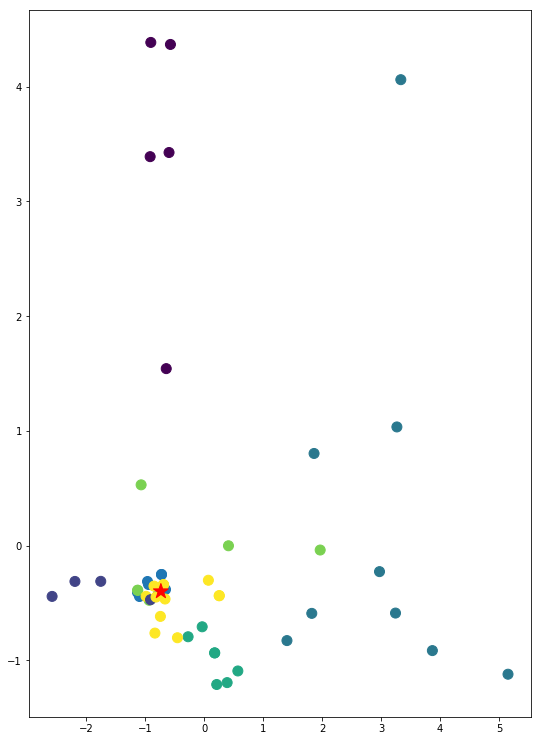

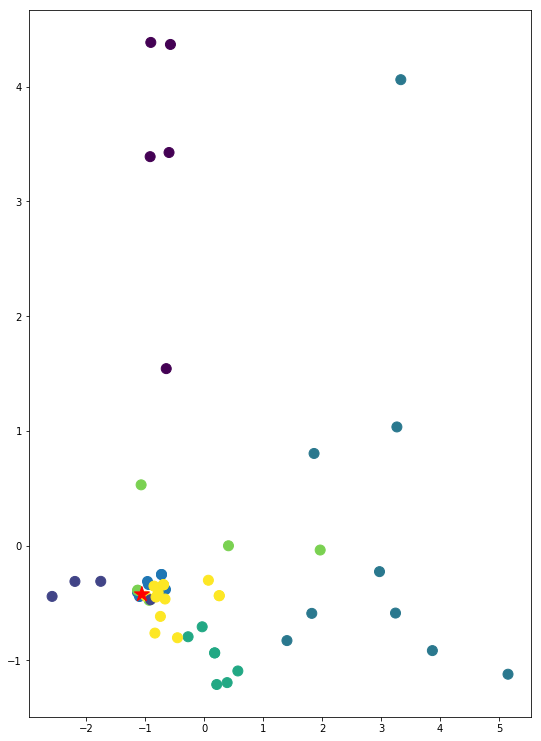

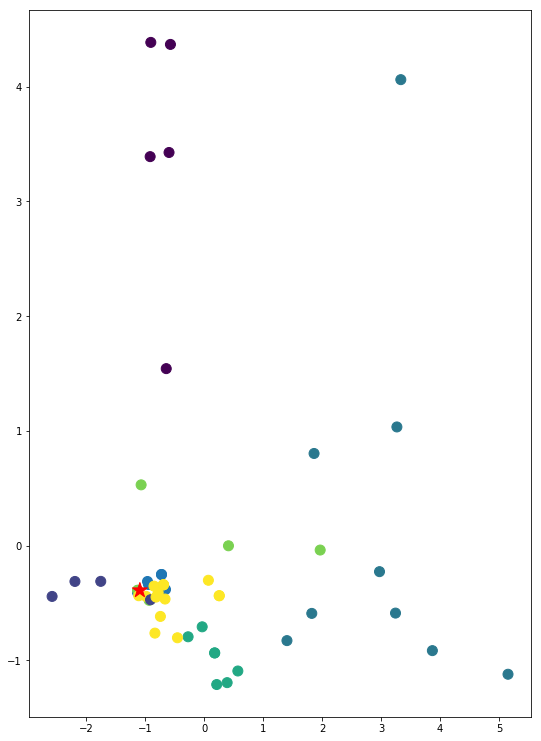

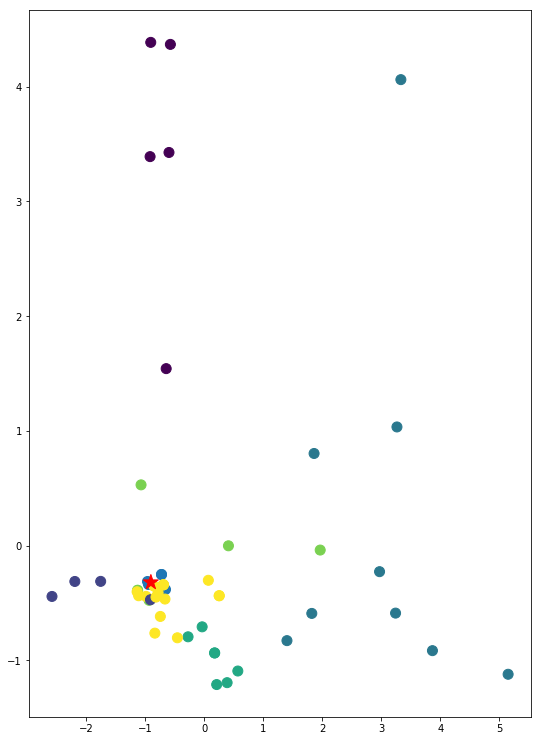

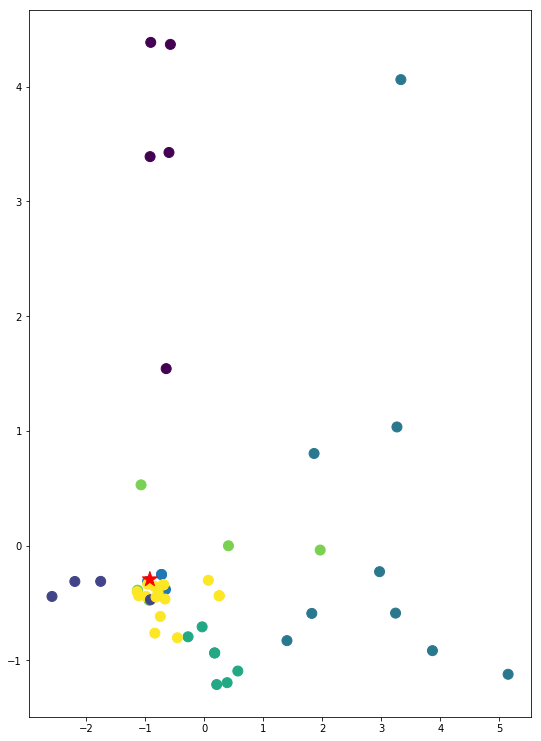

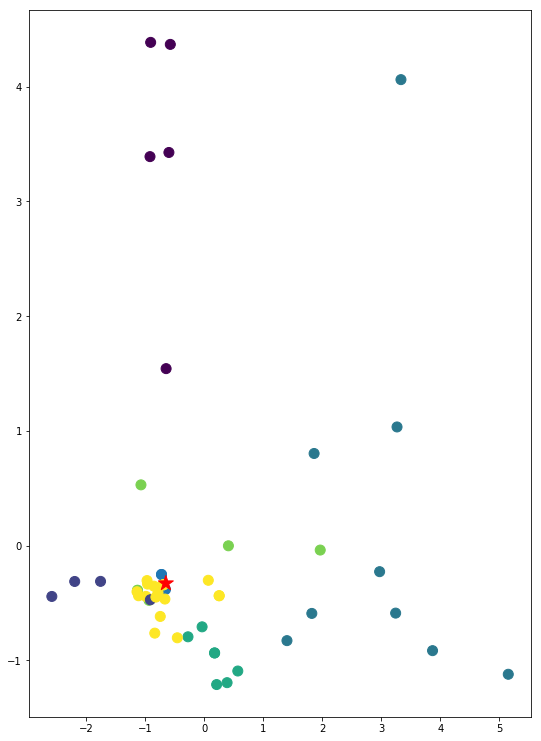

In [84]:
doc = PDFReport()
for i in range(50):
    # Plot sample
    sample_id = get_next_sample(X, Y, W, L)
    
    # Print question
    problem = "Cluster: " + str(y[sample_id] + 1) + "\n" + questions[sample_id]
    solution = solutions[sample_id]
    
    # Plot sample
    plt.figure(figsize=(9,13))
    
    # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
    [nS, nC] = X.shape
    # Create the set of unlabelled samples (U)
    U = np.setdiff1d(np.arange(nS), L)
    
    # Plot unlabeled samples
    plt.scatter(x=sample[U,0], y=sample[U,1], s=100)
    
    # Color by class the ones already labeled
    if L:
        a = plt.scatter(x=sample[L,0], y=sample[L,1], c=y[L], s=100)
    
    # Star the queried sample
    plt.scatter(x=sample[sample_id,0], y=sample[sample_id,1], color='r', marker=r'$\star$', s=400)
    
    # Save figure
    plt.savefig("images/solution_%d.png" % sample_id)
#     print("Question %d" % sample_id)
    
    # Print question
#     problem = questions[sample_id]
#     solution = solutions[sample_id]
    
    # Suppose that the student gets it correctly
    # Update X matrix
    X[sample_id] = Y[sample_id]
    L.append(sample_id)
    doc.append_solution(sample_id, problem, solution)
#     print(X)

doc.generate_pdf("problems_1111")

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).